# Notebook to train CNNs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from monai.networks.nets import ResNet
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

/home/diogommiranda/tese/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-08 20:59:36.460565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-08 20:59:37.060515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


In [2]:
NORMALIZATION = "mni_reg_CV" # Choose intensity normalization method: "minmax"
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 16 # Set batch size

USE_MASK = False # Set to True to use the ROI mask, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
    Found 575 files for class 'smci'
    Found 314 files for class 'pmci'
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
    Found 143 files for class 'smci'
    Found 78 files for class 'pmci'


torch.Size([1, 91, 109, 91])


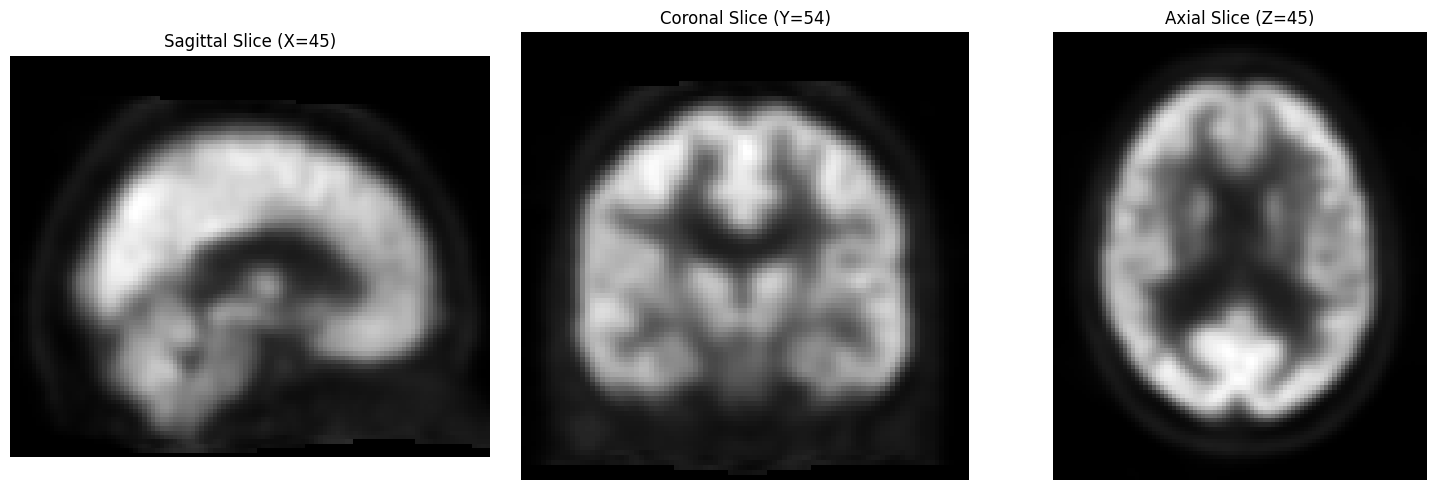

In [3]:
# Verify data with a test sample
i = 2
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    break

In [ ]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation

# para cosine decay
#learning_rates = [5e-4, 2e-4, 1e-4] # adicionar 1e-3? ver os resultados
#weight_decays = [5e-4, 2e-4, 1e-4]

#para fixed_lr
#learning_rates = [1e-5, 2e-5] # adicionar 4e-5 ou 5e-6 dependendo dos resultados
#weight_decays = [2e-4, 1e-4] # adicionar 4e-4 ou 5e-5 dependendo dos resultados

lr_scheduler = "fixed_lr" # Choose between "cosine_decay" or "fixed_lr"

if lr_scheduler == "cosine_decay":
    NUM_EPOCHS = 100
    EARLY_STOP_PATIENCE = 60
    T_max = 100
    eta_min = 0
else:
    NUM_EPOCHS = 100
    EARLY_STOP_PATIENCE = 60

learning_rates = [2e-7] # usar valores a volta do 1e-6 (ate agr a combinacao com l2=1e-4 ou 5e-4 pareceu a melhor com val loss min de 0.24 em 32 epochs)
weight_decays = [2e-4]

tuning_results = []
total_combinations = len(learning_rates) * len(weight_decays)
current_combination_no = 0

if ROI_MASK_PATH is None:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/cosine_decay/" + str(BATCH_SIZE) + "B/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/fixed_lr/" + str(BATCH_SIZE) + "B/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")
else:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/masked/" + DATASET + "/cosine_decay/" + str(BATCH_SIZE) + "B/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/masked/" + DATASET + "/fixed_lr/" + str(BATCH_SIZE) + "B/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

print("\nStarting Hyperparameter Tuning Grid Search...")
overall_start_time = time.time()

# Hyperparameter tuning loop
for current_lr in learning_rates:
    for current_wd in weight_decays: 
        current_combination_no += 1
        print("=" * 60)
        print(f"Testing Combination {current_combination_no}/{total_combinations}: LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
        print("=" * 60)
        start_time_combination = time.time()

        combo_dir_name = f"LR0_{current_lr:.1e}_WD_{current_wd:.0e}" 
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")

        current_combo_val_losses = []
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []

        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                 raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )

            if fold_train_data is None or fold_val_data is None:
                 raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
             
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            model = ResNet(
                block='basic',
                layers=[3, 4, 6, 3],
                block_inplanes=[64, 128, 256, 512],
                spatial_dims=3,
                n_input_channels=1,
                conv1_t_stride=2,
                num_classes=1,
                shortcut_type='B',
                bias_downsample = False
            )
            model.to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            #optimizer = optim.AdamW(model.parameters(), lr=current_lr, weight_decay=current_wd)
            optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)
            #optimizer = optim.SGD(model.parameters(), lr=current_lr, weight_decay=current_wd, momentum=0.9, nesterov=True)
                        
            scheduler = None
            if lr_scheduler == "cosine_decay":
                print("\nUsing Cosine Annealing LR Scheduler.\n")
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    
            best_val_loss = float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # Train phase
                model.train()
                running_loss = 0.0
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())
 
                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # Validation phase
                model.eval()
                val_running_loss = 0.0
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = val_running_loss / len(fold_val_data.dataset)
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                      f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                      f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                
                if scheduler:
                    scheduler.step()

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    # Save the best model state
                    best_model_state = model.state_dict()
                    best_epoch = epoch + 1
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    stopped_epoch = epoch + 1
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {stopped_epoch - epochs_no_improve}.\n")
                    break
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history['val_loss'][best_epoch_index]
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            optimizer_name = optimizer.__class__.__name__
            optimizer_params = {
                'lr': float(current_lr),
                'weight_decay': float(current_wd)
            }
        
            # Free resources
            del model, optimizer, criterion, scheduler, fold_train_data, fold_val_data, history, history_df, best_model_state
            if device.type == 'cuda':
                torch.cuda.empty_cache() 
            gc.collect() 
            
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)

        print("-" * 50)
        print(f"Results for LR={current_lr}, WeightDecay={current_wd} (Across {N_SPLITS} Folds):")
        print(f"  Avg Val Loss: {avg_loss:.4f} +/- {std_loss:.4f}")
        print(f"  Avg Val Acc:  {avg_acc:.4f} +/- {std_acc:.4f}")
        print(f"  Avg Val AUC:  {avg_auc:.4f} +/- {std_auc:.4f}")
        print("-" * 50)

        # Store results
        
        combo_average_results = {
            'learning_rate': current_lr,
            'weight_decay': current_wd,
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch)
        }
        
        tuning_results.append(combo_average_results)
        
        results_df = pd.DataFrame(combo_average_results)
        display_cols = list(combo_average_results.keys())
        
        results_file_path = os.path.join(combo_results_dir, "resultados.txt")
        with open(results_file_path, "w") as f:
            print("\nTuning Results Summary:", file=f)
            print(results_df[display_cols].round(6).to_string(index=False), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)
        
        training_config = {
            "num_folds": N_SPLITS,
            "num_epochs": NUM_EPOCHS,
            "early_stop_patience": EARLY_STOP_PATIENCE,
            "lr_scheduler": lr_scheduler,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(optimizer_params['lr']),
                "weight_decay": float(optimizer_params['weight_decay'])
            },
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(combo_results_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)

        end_time_combination = time.time()
        print(f"Combination {current_combination_no} finished in {end_time_combination - start_time_combination:.2f} seconds.")
        


Results will be saved to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/16B/

Starting Hyperparameter Tuning Grid Search...
Testing Combination 1/1: LR=2.0e-07, WeightDecay=2e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/16B/LR0_2.0e-07_WD_2e-04
------------------------------------------------------------
Training Fold 1/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 726, Validation samples: 163
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 472, 1: 254}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8583


  1%|          | 1/100 [00:06<09:59,  6.06s/it]

    Epoch 1/100 [6.05s] - Train Loss: 0.91997, Train Acc: 0.34986 | Val Loss: 0.91462, Val Acc: 0.36810


  2%|▏         | 2/100 [00:11<09:46,  5.99s/it]

    Epoch 2/100 [5.94s] - Train Loss: 0.90459, Train Acc: 0.34986 | Val Loss: 0.91451, Val Acc: 0.36810


  3%|▎         | 3/100 [00:17<09:39,  5.97s/it]

    Epoch 3/100 [5.95s] - Train Loss: 0.89301, Train Acc: 0.35262 | Val Loss: 0.89602, Val Acc: 0.37423


  4%|▍         | 4/100 [00:26<11:05,  6.94s/it]

    Epoch 4/100 [8.42s] - Train Loss: 0.87819, Train Acc: 0.35950 | Val Loss: 0.89000, Val Acc: 0.38037


  5%|▌         | 5/100 [00:32<10:24,  6.58s/it]

    Epoch 5/100 [5.93s] - Train Loss: 0.86262, Train Acc: 0.37879 | Val Loss: 0.88356, Val Acc: 0.38650


  6%|▌         | 6/100 [00:38<09:58,  6.37s/it]

    Epoch 6/100 [5.95s] - Train Loss: 0.85038, Train Acc: 0.41736 | Val Loss: 0.87844, Val Acc: 0.44172


  7%|▋         | 7/100 [00:44<09:36,  6.20s/it]

    Epoch 7/100 [5.84s] - Train Loss: 0.83978, Train Acc: 0.47658 | Val Loss: 0.87439, Val Acc: 0.48466


  8%|▊         | 8/100 [00:49<09:17,  6.06s/it]

    Epoch 8/100 [5.76s] - Train Loss: 0.82530, Train Acc: 0.57300 | Val Loss: 0.86940, Val Acc: 0.53988


  9%|▉         | 9/100 [00:57<09:59,  6.59s/it]

    Epoch 9/100 [7.75s] - Train Loss: 0.81501, Train Acc: 0.62534 | Val Loss: 0.86371, Val Acc: 0.60736


 10%|█         | 10/100 [01:03<09:32,  6.36s/it]

    Epoch 10/100 [5.86s] - Train Loss: 0.80634, Train Acc: 0.67080 | Val Loss: 0.85925, Val Acc: 0.60123


 11%|█         | 11/100 [01:09<09:12,  6.20s/it]

    Epoch 11/100 [5.84s] - Train Loss: 0.79448, Train Acc: 0.73691 | Val Loss: 0.85430, Val Acc: 0.63190


 12%|█▏        | 12/100 [01:15<09:07,  6.22s/it]

    Epoch 12/100 [6.26s] - Train Loss: 0.78074, Train Acc: 0.75620 | Val Loss: 0.85002, Val Acc: 0.68712


 13%|█▎        | 13/100 [01:21<08:57,  6.17s/it]

    Epoch 13/100 [6.06s] - Train Loss: 0.77049, Train Acc: 0.80165 | Val Loss: 0.84528, Val Acc: 0.73620


 14%|█▍        | 14/100 [01:27<08:46,  6.13s/it]

    Epoch 14/100 [6.02s] - Train Loss: 0.75662, Train Acc: 0.82231 | Val Loss: 0.84090, Val Acc: 0.71779


 15%|█▌        | 15/100 [01:34<08:58,  6.33s/it]

    Epoch 15/100 [6.81s] - Train Loss: 0.74192, Train Acc: 0.83884 | Val Loss: 0.83566, Val Acc: 0.73006


 16%|█▌        | 16/100 [01:40<08:43,  6.23s/it]

    Epoch 16/100 [5.99s] - Train Loss: 0.73557, Train Acc: 0.83747 | Val Loss: 0.83118, Val Acc: 0.75460


 17%|█▋        | 17/100 [01:46<08:31,  6.16s/it]

    Epoch 17/100 [6.01s] - Train Loss: 0.72068, Train Acc: 0.85675 | Val Loss: 0.82477, Val Acc: 0.74847


 18%|█▊        | 18/100 [01:52<08:23,  6.14s/it]

    Epoch 18/100 [6.08s] - Train Loss: 0.71020, Train Acc: 0.86777 | Val Loss: 0.82007, Val Acc: 0.74847


 19%|█▉        | 19/100 [01:58<08:15,  6.12s/it]

    Epoch 19/100 [6.06s] - Train Loss: 0.69638, Train Acc: 0.86364 | Val Loss: 0.81430, Val Acc: 0.75460


 20%|██        | 20/100 [02:05<08:30,  6.38s/it]

    Epoch 20/100 [6.99s] - Train Loss: 0.68444, Train Acc: 0.87741 | Val Loss: 0.81036, Val Acc: 0.76074


 21%|██        | 21/100 [02:12<08:24,  6.38s/it]

    Epoch 21/100 [6.39s] - Train Loss: 0.66872, Train Acc: 0.89394 | Val Loss: 0.80384, Val Acc: 0.74847


 22%|██▏       | 22/100 [02:18<08:13,  6.32s/it]

    Epoch 22/100 [6.18s] - Train Loss: 0.65343, Train Acc: 0.90083 | Val Loss: 0.79823, Val Acc: 0.76074


 23%|██▎       | 23/100 [02:24<07:57,  6.20s/it]

    Epoch 23/100 [5.92s] - Train Loss: 0.63684, Train Acc: 0.88292 | Val Loss: 0.79033, Val Acc: 0.75460


 24%|██▍       | 24/100 [02:30<07:50,  6.18s/it]

    Epoch 24/100 [6.14s] - Train Loss: 0.63075, Train Acc: 0.89807 | Val Loss: 0.78879, Val Acc: 0.77301


 25%|██▌       | 25/100 [02:36<07:56,  6.35s/it]

    Epoch 25/100 [6.73s] - Train Loss: 0.60537, Train Acc: 0.90771 | Val Loss: 0.78095, Val Acc: 0.78528


 26%|██▌       | 26/100 [02:42<07:40,  6.22s/it]

    Epoch 26/100 [5.92s] - Train Loss: 0.60029, Train Acc: 0.90909 | Val Loss: 0.77597, Val Acc: 0.79141


 27%|██▋       | 27/100 [02:48<07:31,  6.18s/it]

    Epoch 27/100 [6.08s] - Train Loss: 0.57101, Train Acc: 0.91047 | Val Loss: 0.76682, Val Acc: 0.74847


 28%|██▊       | 28/100 [02:55<07:24,  6.17s/it]

    Epoch 28/100 [6.14s] - Train Loss: 0.57184, Train Acc: 0.90496 | Val Loss: 0.76294, Val Acc: 0.76687


 29%|██▉       | 29/100 [03:01<07:18,  6.18s/it]

    Epoch 29/100 [6.22s] - Train Loss: 0.54917, Train Acc: 0.91460 | Val Loss: 0.75999, Val Acc: 0.77914


 30%|███       | 30/100 [03:07<07:13,  6.19s/it]

    Epoch 30/100 [6.20s] - Train Loss: 0.53496, Train Acc: 0.91322 | Val Loss: 0.75538, Val Acc: 0.78528


 31%|███       | 31/100 [03:14<07:16,  6.33s/it]

    Epoch 31/100 [6.65s] - Train Loss: 0.51931, Train Acc: 0.91322 | Val Loss: 0.74029, Val Acc: 0.74233


 32%|███▏      | 32/100 [03:20<07:05,  6.25s/it]

    Epoch 32/100 [6.07s] - Train Loss: 0.49737, Train Acc: 0.91598 | Val Loss: 0.74385, Val Acc: 0.79755


 33%|███▎      | 33/100 [03:26<06:58,  6.25s/it]

    Epoch 33/100 [6.25s] - Train Loss: 0.48312, Train Acc: 0.92700 | Val Loss: 0.74596, Val Acc: 0.79141


 34%|███▍      | 34/100 [03:32<06:51,  6.24s/it]

    Epoch 34/100 [6.21s] - Train Loss: 0.46447, Train Acc: 0.93251 | Val Loss: 0.72529, Val Acc: 0.77914


 35%|███▌      | 35/100 [03:38<06:42,  6.19s/it]

    Epoch 35/100 [6.08s] - Train Loss: 0.44992, Train Acc: 0.91460 | Val Loss: 0.72257, Val Acc: 0.79141


 36%|███▌      | 36/100 [03:45<06:47,  6.36s/it]

    Epoch 36/100 [6.77s] - Train Loss: 0.42778, Train Acc: 0.92837 | Val Loss: 0.72412, Val Acc: 0.80368


 37%|███▋      | 37/100 [03:51<06:39,  6.34s/it]

    Epoch 37/100 [6.30s] - Train Loss: 0.43048, Train Acc: 0.92424 | Val Loss: 0.70848, Val Acc: 0.78528


 38%|███▊      | 38/100 [03:58<06:32,  6.33s/it]

    Epoch 38/100 [6.28s] - Train Loss: 0.40879, Train Acc: 0.92562 | Val Loss: 0.70763, Val Acc: 0.80368


 39%|███▉      | 39/100 [04:04<06:26,  6.33s/it]

    Epoch 39/100 [6.35s] - Train Loss: 0.37464, Train Acc: 0.94077 | Val Loss: 0.70490, Val Acc: 0.80982


 40%|████      | 40/100 [04:10<06:19,  6.33s/it]

    Epoch 40/100 [6.31s] - Train Loss: 0.37413, Train Acc: 0.93802 | Val Loss: 0.69792, Val Acc: 0.80982


 41%|████      | 41/100 [04:17<06:19,  6.44s/it]

    Epoch 41/100 [6.69s] - Train Loss: 0.34915, Train Acc: 0.94766 | Val Loss: 0.68375, Val Acc: 0.77914


 42%|████▏     | 42/100 [04:23<06:08,  6.36s/it]

    Epoch 42/100 [6.19s] - Train Loss: 0.34117, Train Acc: 0.95179 | Val Loss: 0.70168, Val Acc: 0.80982


 43%|████▎     | 43/100 [04:30<06:07,  6.44s/it]

    Epoch 43/100 [6.63s] - Train Loss: 0.32463, Train Acc: 0.94766 | Val Loss: 0.68976, Val Acc: 0.80982


 44%|████▍     | 44/100 [04:36<05:57,  6.39s/it]

    Epoch 44/100 [6.27s] - Train Loss: 0.29206, Train Acc: 0.95868 | Val Loss: 0.68650, Val Acc: 0.80982


 45%|████▌     | 45/100 [04:42<05:47,  6.33s/it]

    Epoch 45/100 [6.18s] - Train Loss: 0.31295, Train Acc: 0.96143 | Val Loss: 0.66789, Val Acc: 0.78528


 46%|████▌     | 46/100 [04:49<05:48,  6.45s/it]

    Epoch 46/100 [6.75s] - Train Loss: 0.28033, Train Acc: 0.96556 | Val Loss: 0.68647, Val Acc: 0.80982


 47%|████▋     | 47/100 [04:55<05:39,  6.41s/it]

    Epoch 47/100 [6.30s] - Train Loss: 0.27592, Train Acc: 0.96143 | Val Loss: 0.66614, Val Acc: 0.79755


 48%|████▊     | 48/100 [05:02<05:30,  6.36s/it]

    Epoch 48/100 [6.25s] - Train Loss: 0.25650, Train Acc: 0.97796 | Val Loss: 0.67990, Val Acc: 0.80982


 49%|████▉     | 49/100 [05:08<05:21,  6.30s/it]

    Epoch 49/100 [6.16s] - Train Loss: 0.25548, Train Acc: 0.95868 | Val Loss: 0.68910, Val Acc: 0.80368


 50%|█████     | 50/100 [05:14<05:12,  6.25s/it]

    Epoch 50/100 [6.13s] - Train Loss: 0.24428, Train Acc: 0.96970 | Val Loss: 0.65937, Val Acc: 0.80368


 51%|█████     | 51/100 [05:21<05:14,  6.42s/it]

    Epoch 51/100 [6.82s] - Train Loss: 0.21678, Train Acc: 0.97383 | Val Loss: 0.65692, Val Acc: 0.80368


 52%|█████▏    | 52/100 [05:27<05:06,  6.38s/it]

    Epoch 52/100 [6.27s] - Train Loss: 0.22038, Train Acc: 0.96970 | Val Loss: 0.66400, Val Acc: 0.80368


 53%|█████▎    | 53/100 [05:33<04:57,  6.33s/it]

    Epoch 53/100 [6.23s] - Train Loss: 0.22488, Train Acc: 0.96556 | Val Loss: 0.66581, Val Acc: 0.80982


 54%|█████▍    | 54/100 [05:39<04:48,  6.26s/it]

    Epoch 54/100 [6.10s] - Train Loss: 0.18195, Train Acc: 0.97934 | Val Loss: 0.64355, Val Acc: 0.80368


 55%|█████▌    | 55/100 [05:46<04:41,  6.26s/it]

    Epoch 55/100 [6.27s] - Train Loss: 0.18489, Train Acc: 0.99036 | Val Loss: 0.67346, Val Acc: 0.81595


 56%|█████▌    | 56/100 [05:52<04:36,  6.29s/it]

    Epoch 56/100 [6.36s] - Train Loss: 0.17192, Train Acc: 0.98347 | Val Loss: 0.67112, Val Acc: 0.81595


 57%|█████▋    | 57/100 [05:59<04:35,  6.41s/it]

    Epoch 57/100 [6.69s] - Train Loss: 0.17418, Train Acc: 0.98209 | Val Loss: 0.65638, Val Acc: 0.80982


 58%|█████▊    | 58/100 [06:05<04:24,  6.30s/it]

    Epoch 58/100 [6.05s] - Train Loss: 0.15718, Train Acc: 0.98623 | Val Loss: 0.64607, Val Acc: 0.81595


 59%|█████▉    | 59/100 [06:11<04:14,  6.22s/it]

    Epoch 59/100 [6.01s] - Train Loss: 0.15815, Train Acc: 0.98347 | Val Loss: 0.65699, Val Acc: 0.82209


 60%|██████    | 60/100 [06:17<04:08,  6.21s/it]

    Epoch 60/100 [6.20s] - Train Loss: 0.14606, Train Acc: 0.98623 | Val Loss: 0.65169, Val Acc: 0.82209


 61%|██████    | 61/100 [06:23<04:03,  6.23s/it]

    Epoch 61/100 [6.28s] - Train Loss: 0.12861, Train Acc: 0.99725 | Val Loss: 0.64780, Val Acc: 0.82209


 62%|██████▏   | 62/100 [06:30<04:01,  6.36s/it]

    Epoch 62/100 [6.65s] - Train Loss: 0.11748, Train Acc: 0.99174 | Val Loss: 0.65887, Val Acc: 0.80982


 63%|██████▎   | 63/100 [06:36<03:53,  6.30s/it]

    Epoch 63/100 [6.17s] - Train Loss: 0.13333, Train Acc: 0.98760 | Val Loss: 0.64790, Val Acc: 0.82209


 64%|██████▍   | 64/100 [06:42<03:45,  6.27s/it]

    Epoch 64/100 [6.21s] - Train Loss: 0.10663, Train Acc: 0.99174 | Val Loss: 0.67617, Val Acc: 0.81595


 65%|██████▌   | 65/100 [06:48<03:38,  6.25s/it]

    Epoch 65/100 [6.21s] - Train Loss: 0.11562, Train Acc: 0.99449 | Val Loss: 0.69902, Val Acc: 0.80368


 66%|██████▌   | 66/100 [06:54<03:30,  6.19s/it]

    Epoch 66/100 [6.02s] - Train Loss: 0.09126, Train Acc: 0.99862 | Val Loss: 0.67925, Val Acc: 0.80368


 67%|██████▋   | 67/100 [07:01<03:27,  6.29s/it]

    Epoch 67/100 [6.55s] - Train Loss: 0.11182, Train Acc: 0.99449 | Val Loss: 0.66151, Val Acc: 0.82822


 68%|██████▊   | 68/100 [07:07<03:20,  6.26s/it]

    Epoch 68/100 [6.18s] - Train Loss: 0.09841, Train Acc: 0.99449 | Val Loss: 0.71767, Val Acc: 0.78528


 69%|██████▉   | 69/100 [07:13<03:13,  6.24s/it]

    Epoch 69/100 [6.19s] - Train Loss: 0.09619, Train Acc: 0.99311 | Val Loss: 0.64948, Val Acc: 0.82209


 70%|███████   | 70/100 [07:20<03:06,  6.23s/it]

    Epoch 70/100 [6.21s] - Train Loss: 0.09176, Train Acc: 0.99587 | Val Loss: 0.63797, Val Acc: 0.82209


 71%|███████   | 71/100 [07:26<02:59,  6.20s/it]

    Epoch 71/100 [6.12s] - Train Loss: 0.08694, Train Acc: 0.99862 | Val Loss: 0.67751, Val Acc: 0.80982


 72%|███████▏  | 72/100 [07:32<02:57,  6.34s/it]

    Epoch 72/100 [6.67s] - Train Loss: 0.07837, Train Acc: 0.99862 | Val Loss: 0.70909, Val Acc: 0.79755


 73%|███████▎  | 73/100 [07:39<02:50,  6.33s/it]

    Epoch 73/100 [6.29s] - Train Loss: 0.07375, Train Acc: 0.99725 | Val Loss: 0.68906, Val Acc: 0.79755


 74%|███████▍  | 74/100 [07:45<02:43,  6.28s/it]

    Epoch 74/100 [6.18s] - Train Loss: 0.07487, Train Acc: 0.99587 | Val Loss: 0.70120, Val Acc: 0.79755


 75%|███████▌  | 75/100 [07:51<02:35,  6.24s/it]

    Epoch 75/100 [6.13s] - Train Loss: 0.07196, Train Acc: 0.99862 | Val Loss: 0.67342, Val Acc: 0.81595


 76%|███████▌  | 76/100 [07:57<02:27,  6.15s/it]

    Epoch 76/100 [5.94s] - Train Loss: 0.07357, Train Acc: 0.99725 | Val Loss: 0.69021, Val Acc: 0.80368


 77%|███████▋  | 77/100 [08:04<02:24,  6.30s/it]

    Epoch 77/100 [6.64s] - Train Loss: 0.07175, Train Acc: 1.00000 | Val Loss: 0.66538, Val Acc: 0.82209


 78%|███████▊  | 78/100 [08:10<02:18,  6.28s/it]

    Epoch 78/100 [6.24s] - Train Loss: 0.05626, Train Acc: 0.99862 | Val Loss: 0.70462, Val Acc: 0.79755


 79%|███████▉  | 79/100 [08:16<02:11,  6.25s/it]

    Epoch 79/100 [6.18s] - Train Loss: 0.05286, Train Acc: 1.00000 | Val Loss: 0.67428, Val Acc: 0.82209


 80%|████████  | 80/100 [08:22<02:03,  6.18s/it]

    Epoch 80/100 [6.03s] - Train Loss: 0.06057, Train Acc: 1.00000 | Val Loss: 0.67719, Val Acc: 0.80982


 81%|████████  | 81/100 [08:28<01:57,  6.18s/it]

    Epoch 81/100 [6.18s] - Train Loss: 0.06086, Train Acc: 0.99725 | Val Loss: 0.63992, Val Acc: 0.79141


 82%|████████▏ | 82/100 [08:35<01:52,  6.23s/it]

    Epoch 82/100 [6.32s] - Train Loss: 0.05990, Train Acc: 1.00000 | Val Loss: 0.72700, Val Acc: 0.79755


 83%|████████▎ | 83/100 [08:41<01:48,  6.37s/it]

    Epoch 83/100 [6.71s] - Train Loss: 0.06035, Train Acc: 0.99174 | Val Loss: 0.75981, Val Acc: 0.78528


 84%|████████▍ | 84/100 [08:48<01:42,  6.40s/it]

    Epoch 84/100 [6.47s] - Train Loss: 0.04709, Train Acc: 1.00000 | Val Loss: 0.66395, Val Acc: 0.83436


 85%|████████▌ | 85/100 [08:54<01:35,  6.39s/it]

    Epoch 85/100 [6.37s] - Train Loss: 0.05234, Train Acc: 1.00000 | Val Loss: 0.77470, Val Acc: 0.76687


 86%|████████▌ | 86/100 [09:01<01:29,  6.42s/it]

    Epoch 86/100 [6.47s] - Train Loss: 0.04893, Train Acc: 0.99725 | Val Loss: 0.68761, Val Acc: 0.80982


 87%|████████▋ | 87/100 [09:07<01:23,  6.43s/it]

    Epoch 87/100 [6.46s] - Train Loss: 0.04274, Train Acc: 0.99862 | Val Loss: 0.73649, Val Acc: 0.79141


 88%|████████▊ | 88/100 [09:13<01:16,  6.41s/it]

    Epoch 88/100 [6.37s] - Train Loss: 0.03651, Train Acc: 1.00000 | Val Loss: 0.74491, Val Acc: 0.79755


 89%|████████▉ | 89/100 [09:20<01:10,  6.39s/it]

    Epoch 89/100 [6.35s] - Train Loss: 0.05145, Train Acc: 0.99587 | Val Loss: 0.79373, Val Acc: 0.76687


 90%|█████████ | 90/100 [09:26<01:03,  6.33s/it]

    Epoch 90/100 [6.20s] - Train Loss: 0.04527, Train Acc: 0.99725 | Val Loss: 0.78804, Val Acc: 0.77301


 91%|█████████ | 91/100 [09:32<00:57,  6.34s/it]

    Epoch 91/100 [6.34s] - Train Loss: 0.03600, Train Acc: 1.00000 | Val Loss: 0.68455, Val Acc: 0.82209


 92%|█████████▏| 92/100 [09:38<00:50,  6.30s/it]

    Epoch 92/100 [6.20s] - Train Loss: 0.03765, Train Acc: 1.00000 | Val Loss: 0.70908, Val Acc: 0.80982


 93%|█████████▎| 93/100 [09:45<00:44,  6.29s/it]

    Epoch 93/100 [6.29s] - Train Loss: 0.03697, Train Acc: 1.00000 | Val Loss: 0.70172, Val Acc: 0.80982


 94%|█████████▍| 94/100 [09:51<00:37,  6.30s/it]

    Epoch 94/100 [6.30s] - Train Loss: 0.03522, Train Acc: 1.00000 | Val Loss: 0.73922, Val Acc: 0.80368


 95%|█████████▌| 95/100 [09:57<00:31,  6.28s/it]

    Epoch 95/100 [6.23s] - Train Loss: 0.03322, Train Acc: 1.00000 | Val Loss: 0.77075, Val Acc: 0.79755


 96%|█████████▌| 96/100 [10:03<00:24,  6.23s/it]

    Epoch 96/100 [6.12s] - Train Loss: 0.03658, Train Acc: 0.99862 | Val Loss: 0.76117, Val Acc: 0.79755


 97%|█████████▋| 97/100 [10:10<00:18,  6.26s/it]

    Epoch 97/100 [6.32s] - Train Loss: 0.03015, Train Acc: 0.99862 | Val Loss: 0.69591, Val Acc: 0.80982


 98%|█████████▊| 98/100 [10:16<00:12,  6.28s/it]

    Epoch 98/100 [6.35s] - Train Loss: 0.02997, Train Acc: 1.00000 | Val Loss: 0.69704, Val Acc: 0.81595


 99%|█████████▉| 99/100 [10:23<00:06,  6.33s/it]

    Epoch 99/100 [6.45s] - Train Loss: 0.02885, Train Acc: 1.00000 | Val Loss: 0.85094, Val Acc: 0.76074


100%|██████████| 100/100 [10:29<00:00,  6.29s/it]

    Epoch 100/100 [6.27s] - Train Loss: 0.03029, Train Acc: 1.00000 | Val Loss: 0.76448, Val Acc: 0.79755
Training completed for 100 epochs. Restoring best model weights from epoch 70.
    Fold 1 - Best Epoch 70, Val Loss: 0.6380, Acc: 0.8221, AUC: 0.8559


    Fold 1 finished in 631.37 seconds.
------------------------------------------------------------
Training Fold 2/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 712, Validation samples: 177
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 460, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8254


  1%|          | 1/100 [00:06<10:29,  6.36s/it]

    Epoch 1/100 [6.36s] - Train Loss: 0.91572, Train Acc: 0.35393 | Val Loss: 0.89683, Val Acc: 0.35028


  2%|▏         | 2/100 [00:12<10:14,  6.27s/it]

    Epoch 2/100 [6.20s] - Train Loss: 0.89968, Train Acc: 0.35534 | Val Loss: 0.90755, Val Acc: 0.35028


  3%|▎         | 3/100 [00:18<10:11,  6.31s/it]

    Epoch 3/100 [6.35s] - Train Loss: 0.88636, Train Acc: 0.35393 | Val Loss: 0.89141, Val Acc: 0.35593


  4%|▍         | 4/100 [00:25<10:04,  6.29s/it]

    Epoch 4/100 [6.27s] - Train Loss: 0.86901, Train Acc: 0.35815 | Val Loss: 0.88529, Val Acc: 0.36723


  5%|▌         | 5/100 [00:31<09:54,  6.26s/it]

    Epoch 5/100 [6.20s] - Train Loss: 0.85767, Train Acc: 0.37500 | Val Loss: 0.88054, Val Acc: 0.38418


  6%|▌         | 6/100 [00:37<09:52,  6.30s/it]

    Epoch 6/100 [6.38s] - Train Loss: 0.84169, Train Acc: 0.41713 | Val Loss: 0.87372, Val Acc: 0.41808


  7%|▋         | 7/100 [00:44<09:48,  6.32s/it]

    Epoch 7/100 [6.37s] - Train Loss: 0.83317, Train Acc: 0.47612 | Val Loss: 0.86848, Val Acc: 0.44633


  8%|▊         | 8/100 [00:50<09:40,  6.31s/it]

    Epoch 8/100 [6.28s] - Train Loss: 0.81792, Train Acc: 0.56180 | Val Loss: 0.86486, Val Acc: 0.47458


  9%|▉         | 9/100 [00:56<09:32,  6.29s/it]

    Epoch 9/100 [6.24s] - Train Loss: 0.80768, Train Acc: 0.61798 | Val Loss: 0.85835, Val Acc: 0.55932


 10%|█         | 10/100 [01:02<09:24,  6.27s/it]

    Epoch 10/100 [6.22s] - Train Loss: 0.79411, Train Acc: 0.69382 | Val Loss: 0.85586, Val Acc: 0.57627


 11%|█         | 11/100 [01:09<09:18,  6.28s/it]

    Epoch 11/100 [6.30s] - Train Loss: 0.78352, Train Acc: 0.75702 | Val Loss: 0.85043, Val Acc: 0.62147


 12%|█▏        | 12/100 [01:15<09:13,  6.29s/it]

    Epoch 12/100 [6.30s] - Train Loss: 0.76858, Train Acc: 0.78230 | Val Loss: 0.84605, Val Acc: 0.64972


 13%|█▎        | 13/100 [01:21<09:06,  6.28s/it]

    Epoch 13/100 [6.27s] - Train Loss: 0.76397, Train Acc: 0.80478 | Val Loss: 0.84164, Val Acc: 0.65537


 14%|█▍        | 14/100 [01:28<09:00,  6.28s/it]

    Epoch 14/100 [6.29s] - Train Loss: 0.75001, Train Acc: 0.82303 | Val Loss: 0.83678, Val Acc: 0.68362


 15%|█▌        | 15/100 [01:34<08:53,  6.27s/it]

    Epoch 15/100 [6.25s] - Train Loss: 0.73284, Train Acc: 0.83427 | Val Loss: 0.83414, Val Acc: 0.66667


 16%|█▌        | 16/100 [01:40<08:45,  6.26s/it]

    Epoch 16/100 [6.21s] - Train Loss: 0.71701, Train Acc: 0.88202 | Val Loss: 0.82945, Val Acc: 0.67232


 17%|█▋        | 17/100 [01:46<08:39,  6.26s/it]

    Epoch 17/100 [6.25s] - Train Loss: 0.70971, Train Acc: 0.86376 | Val Loss: 0.82398, Val Acc: 0.70621


 18%|█▊        | 18/100 [01:53<08:32,  6.25s/it]

    Epoch 18/100 [6.24s] - Train Loss: 0.69141, Train Acc: 0.88483 | Val Loss: 0.81922, Val Acc: 0.69492


 19%|█▉        | 19/100 [01:59<08:26,  6.25s/it]

    Epoch 19/100 [6.26s] - Train Loss: 0.68370, Train Acc: 0.87640 | Val Loss: 0.81468, Val Acc: 0.68927


 20%|██        | 20/100 [02:05<08:19,  6.24s/it]

    Epoch 20/100 [6.20s] - Train Loss: 0.66974, Train Acc: 0.88343 | Val Loss: 0.81093, Val Acc: 0.68362


 21%|██        | 21/100 [02:11<08:14,  6.27s/it]

    Epoch 21/100 [6.32s] - Train Loss: 0.65290, Train Acc: 0.89888 | Val Loss: 0.80609, Val Acc: 0.72316


 22%|██▏       | 22/100 [02:18<08:10,  6.29s/it]

    Epoch 22/100 [6.35s] - Train Loss: 0.63482, Train Acc: 0.89607 | Val Loss: 0.80120, Val Acc: 0.70056


 23%|██▎       | 23/100 [02:24<08:05,  6.31s/it]

    Epoch 23/100 [6.35s] - Train Loss: 0.62672, Train Acc: 0.90028 | Val Loss: 0.79651, Val Acc: 0.68362


 24%|██▍       | 24/100 [02:30<08:01,  6.34s/it]

    Epoch 24/100 [6.40s] - Train Loss: 0.61926, Train Acc: 0.89607 | Val Loss: 0.79165, Val Acc: 0.69492


 25%|██▌       | 25/100 [02:37<07:55,  6.34s/it]

    Epoch 25/100 [6.35s] - Train Loss: 0.59331, Train Acc: 0.90449 | Val Loss: 0.78597, Val Acc: 0.71186


 26%|██▌       | 26/100 [02:43<07:47,  6.32s/it]

    Epoch 26/100 [6.26s] - Train Loss: 0.57943, Train Acc: 0.90590 | Val Loss: 0.78145, Val Acc: 0.69492


 27%|██▋       | 27/100 [02:49<07:37,  6.26s/it]

    Epoch 27/100 [6.14s] - Train Loss: 0.56616, Train Acc: 0.91292 | Val Loss: 0.77676, Val Acc: 0.71751


 28%|██▊       | 28/100 [02:55<07:30,  6.26s/it]

    Epoch 28/100 [6.25s] - Train Loss: 0.54861, Train Acc: 0.91011 | Val Loss: 0.77235, Val Acc: 0.70056


 29%|██▉       | 29/100 [03:02<07:24,  6.27s/it]

    Epoch 29/100 [6.27s] - Train Loss: 0.53295, Train Acc: 0.90871 | Val Loss: 0.76894, Val Acc: 0.71186


 30%|███       | 30/100 [03:08<07:19,  6.27s/it]

    Epoch 30/100 [6.29s] - Train Loss: 0.52356, Train Acc: 0.90871 | Val Loss: 0.76400, Val Acc: 0.67797


 31%|███       | 31/100 [03:14<07:15,  6.30s/it]

    Epoch 31/100 [6.37s] - Train Loss: 0.50546, Train Acc: 0.92275 | Val Loss: 0.75889, Val Acc: 0.70621


 32%|███▏      | 32/100 [03:21<07:08,  6.30s/it]

    Epoch 32/100 [6.27s] - Train Loss: 0.48412, Train Acc: 0.92697 | Val Loss: 0.75362, Val Acc: 0.70621


 33%|███▎      | 33/100 [03:27<07:02,  6.30s/it]

    Epoch 33/100 [6.31s] - Train Loss: 0.46633, Train Acc: 0.92416 | Val Loss: 0.75128, Val Acc: 0.71186


 34%|███▍      | 34/100 [03:33<06:54,  6.28s/it]

    Epoch 34/100 [6.22s] - Train Loss: 0.45440, Train Acc: 0.91994 | Val Loss: 0.74708, Val Acc: 0.71186


 35%|███▌      | 35/100 [03:39<06:48,  6.28s/it]

    Epoch 35/100 [6.28s] - Train Loss: 0.43037, Train Acc: 0.93258 | Val Loss: 0.74359, Val Acc: 0.70621


 36%|███▌      | 36/100 [03:46<06:43,  6.30s/it]

    Epoch 36/100 [6.35s] - Train Loss: 0.42493, Train Acc: 0.93258 | Val Loss: 0.73915, Val Acc: 0.70621


 37%|███▋      | 37/100 [03:52<06:35,  6.28s/it]

    Epoch 37/100 [6.22s] - Train Loss: 0.40323, Train Acc: 0.94101 | Val Loss: 0.73768, Val Acc: 0.68362


 38%|███▊      | 38/100 [03:58<06:27,  6.25s/it]

    Epoch 38/100 [6.20s] - Train Loss: 0.39367, Train Acc: 0.93539 | Val Loss: 0.73487, Val Acc: 0.70621


 39%|███▉      | 39/100 [04:04<06:21,  6.26s/it]

    Epoch 39/100 [6.26s] - Train Loss: 0.37348, Train Acc: 0.93961 | Val Loss: 0.73302, Val Acc: 0.70621


 40%|████      | 40/100 [04:11<06:15,  6.26s/it]

    Epoch 40/100 [6.26s] - Train Loss: 0.35111, Train Acc: 0.94663 | Val Loss: 0.73098, Val Acc: 0.69492


 41%|████      | 41/100 [04:17<06:08,  6.24s/it]

    Epoch 41/100 [6.20s] - Train Loss: 0.34209, Train Acc: 0.94803 | Val Loss: 0.73073, Val Acc: 0.71751


 42%|████▏     | 42/100 [04:23<06:01,  6.24s/it]

    Epoch 42/100 [6.24s] - Train Loss: 0.33147, Train Acc: 0.94944 | Val Loss: 0.72778, Val Acc: 0.70621


 43%|████▎     | 43/100 [04:29<05:55,  6.23s/it]

    Epoch 43/100 [6.22s] - Train Loss: 0.31281, Train Acc: 0.95506 | Val Loss: 0.72728, Val Acc: 0.71186


 44%|████▍     | 44/100 [04:36<05:49,  6.23s/it]

    Epoch 44/100 [6.23s] - Train Loss: 0.30961, Train Acc: 0.94382 | Val Loss: 0.73051, Val Acc: 0.70056


 45%|████▌     | 45/100 [04:42<05:45,  6.29s/it]

    Epoch 45/100 [6.41s] - Train Loss: 0.27965, Train Acc: 0.96348 | Val Loss: 0.72630, Val Acc: 0.71186


 46%|████▌     | 46/100 [04:49<05:42,  6.34s/it]

    Epoch 46/100 [6.48s] - Train Loss: 0.26402, Train Acc: 0.96067 | Val Loss: 0.72283, Val Acc: 0.70621


 47%|████▋     | 47/100 [04:55<05:33,  6.30s/it]

    Epoch 47/100 [6.20s] - Train Loss: 0.25231, Train Acc: 0.97472 | Val Loss: 0.72384, Val Acc: 0.71751


 48%|████▊     | 48/100 [05:01<05:24,  6.25s/it]

    Epoch 48/100 [6.13s] - Train Loss: 0.25748, Train Acc: 0.96629 | Val Loss: 0.72272, Val Acc: 0.70056


 49%|████▉     | 49/100 [05:07<05:17,  6.23s/it]

    Epoch 49/100 [6.18s] - Train Loss: 0.24465, Train Acc: 0.95927 | Val Loss: 0.72865, Val Acc: 0.70056


 50%|█████     | 50/100 [05:13<05:10,  6.21s/it]

    Epoch 50/100 [6.16s] - Train Loss: 0.23484, Train Acc: 0.96489 | Val Loss: 0.72232, Val Acc: 0.70621


 51%|█████     | 51/100 [05:19<05:03,  6.20s/it]

    Epoch 51/100 [6.18s] - Train Loss: 0.21082, Train Acc: 0.97893 | Val Loss: 0.72600, Val Acc: 0.68927


 52%|█████▏    | 52/100 [05:26<04:59,  6.23s/it]

    Epoch 52/100 [6.31s] - Train Loss: 0.20607, Train Acc: 0.97191 | Val Loss: 0.72566, Val Acc: 0.70621


 53%|█████▎    | 53/100 [05:32<04:54,  6.27s/it]

    Epoch 53/100 [6.35s] - Train Loss: 0.20946, Train Acc: 0.97331 | Val Loss: 0.72360, Val Acc: 0.70056


 54%|█████▍    | 54/100 [05:38<04:48,  6.28s/it]

    Epoch 54/100 [6.31s] - Train Loss: 0.20266, Train Acc: 0.97051 | Val Loss: 0.73000, Val Acc: 0.71751


 55%|█████▌    | 55/100 [05:45<04:43,  6.30s/it]

    Epoch 55/100 [6.33s] - Train Loss: 0.18651, Train Acc: 0.98736 | Val Loss: 0.72507, Val Acc: 0.69492


 56%|█████▌    | 56/100 [05:51<04:36,  6.29s/it]

    Epoch 56/100 [6.28s] - Train Loss: 0.17222, Train Acc: 0.98596 | Val Loss: 0.72290, Val Acc: 0.71751


 57%|█████▋    | 57/100 [05:57<04:31,  6.32s/it]

    Epoch 57/100 [6.38s] - Train Loss: 0.17041, Train Acc: 0.97753 | Val Loss: 0.72481, Val Acc: 0.71751


 58%|█████▊    | 58/100 [06:03<04:23,  6.27s/it]

    Epoch 58/100 [6.14s] - Train Loss: 0.15869, Train Acc: 0.98034 | Val Loss: 0.72761, Val Acc: 0.70056


 59%|█████▉    | 59/100 [06:10<04:16,  6.26s/it]

    Epoch 59/100 [6.25s] - Train Loss: 0.14490, Train Acc: 0.99157 | Val Loss: 0.72716, Val Acc: 0.72881


 60%|██████    | 60/100 [06:16<04:12,  6.30s/it]

    Epoch 60/100 [6.39s] - Train Loss: 0.15216, Train Acc: 0.98876 | Val Loss: 0.72816, Val Acc: 0.71751


 61%|██████    | 61/100 [06:23<04:07,  6.34s/it]

    Epoch 61/100 [6.43s] - Train Loss: 0.13219, Train Acc: 0.99157 | Val Loss: 0.73134, Val Acc: 0.70056


 62%|██████▏   | 62/100 [06:29<04:00,  6.32s/it]

    Epoch 62/100 [6.28s] - Train Loss: 0.12843, Train Acc: 0.98876 | Val Loss: 0.73975, Val Acc: 0.73446


 63%|██████▎   | 63/100 [06:35<03:52,  6.28s/it]

    Epoch 63/100 [6.17s] - Train Loss: 0.11388, Train Acc: 0.99157 | Val Loss: 0.73287, Val Acc: 0.72881


 64%|██████▍   | 64/100 [06:41<03:44,  6.24s/it]

    Epoch 64/100 [6.16s] - Train Loss: 0.12022, Train Acc: 0.98455 | Val Loss: 0.74144, Val Acc: 0.72881


 65%|██████▌   | 65/100 [06:47<03:38,  6.25s/it]

    Epoch 65/100 [6.26s] - Train Loss: 0.12129, Train Acc: 0.99298 | Val Loss: 0.73333, Val Acc: 0.71751


 66%|██████▌   | 66/100 [06:54<03:35,  6.34s/it]

    Epoch 66/100 [6.55s] - Train Loss: 0.10694, Train Acc: 0.99298 | Val Loss: 0.73810, Val Acc: 0.73446


 67%|██████▋   | 67/100 [07:01<03:32,  6.45s/it]

    Epoch 67/100 [6.70s] - Train Loss: 0.10066, Train Acc: 0.99298 | Val Loss: 0.74462, Val Acc: 0.73446


 68%|██████▊   | 68/100 [07:07<03:23,  6.37s/it]

    Epoch 68/100 [6.19s] - Train Loss: 0.10277, Train Acc: 0.98736 | Val Loss: 0.74244, Val Acc: 0.72881


 69%|██████▉   | 69/100 [07:13<03:16,  6.35s/it]

    Epoch 69/100 [6.31s] - Train Loss: 0.09797, Train Acc: 0.98736 | Val Loss: 0.74278, Val Acc: 0.73446


 70%|███████   | 70/100 [07:19<03:09,  6.33s/it]

    Epoch 70/100 [6.28s] - Train Loss: 0.08829, Train Acc: 0.99579 | Val Loss: 0.74542, Val Acc: 0.73446


 71%|███████   | 71/100 [07:26<03:06,  6.43s/it]

    Epoch 71/100 [6.65s] - Train Loss: 0.08684, Train Acc: 0.99438 | Val Loss: 0.77086, Val Acc: 0.70056


 72%|███████▏  | 72/100 [07:33<03:02,  6.51s/it]

    Epoch 72/100 [6.70s] - Train Loss: 0.07199, Train Acc: 0.99860 | Val Loss: 0.74563, Val Acc: 0.73446


 73%|███████▎  | 73/100 [07:39<02:53,  6.43s/it]

    Epoch 73/100 [6.24s] - Train Loss: 0.09001, Train Acc: 0.99298 | Val Loss: 0.78133, Val Acc: 0.76271


 74%|███████▍  | 74/100 [07:45<02:46,  6.40s/it]

    Epoch 74/100 [6.33s] - Train Loss: 0.08161, Train Acc: 0.99438 | Val Loss: 0.74836, Val Acc: 0.74011


 75%|███████▌  | 75/100 [07:52<02:40,  6.42s/it]

    Epoch 75/100 [6.45s] - Train Loss: 0.07232, Train Acc: 0.99579 | Val Loss: 0.75295, Val Acc: 0.72316


 76%|███████▌  | 76/100 [07:58<02:32,  6.36s/it]

    Epoch 76/100 [6.23s] - Train Loss: 0.08092, Train Acc: 0.99157 | Val Loss: 0.75621, Val Acc: 0.72881


 77%|███████▋  | 77/100 [08:04<02:25,  6.32s/it]

    Epoch 77/100 [6.23s] - Train Loss: 0.06362, Train Acc: 0.99719 | Val Loss: 0.75080, Val Acc: 0.74576


 78%|███████▊  | 78/100 [08:11<02:19,  6.33s/it]

    Epoch 78/100 [6.33s] - Train Loss: 0.06115, Train Acc: 0.99860 | Val Loss: 0.75319, Val Acc: 0.74576


 79%|███████▉  | 79/100 [08:17<02:11,  6.28s/it]

    Epoch 79/100 [6.19s] - Train Loss: 0.05856, Train Acc: 1.00000 | Val Loss: 0.76369, Val Acc: 0.72881


 80%|████████  | 80/100 [08:23<02:05,  6.28s/it]

    Epoch 80/100 [6.27s] - Train Loss: 0.06236, Train Acc: 0.99860 | Val Loss: 0.76529, Val Acc: 0.74011


 81%|████████  | 81/100 [08:29<01:59,  6.30s/it]

    Epoch 81/100 [6.35s] - Train Loss: 0.04760, Train Acc: 1.00000 | Val Loss: 0.76323, Val Acc: 0.73446


 82%|████████▏ | 82/100 [08:36<01:52,  6.27s/it]

    Epoch 82/100 [6.18s] - Train Loss: 0.04926, Train Acc: 1.00000 | Val Loss: 0.78181, Val Acc: 0.75141


 83%|████████▎ | 83/100 [08:42<01:46,  6.24s/it]

    Epoch 83/100 [6.17s] - Train Loss: 0.05613, Train Acc: 1.00000 | Val Loss: 0.76997, Val Acc: 0.73446


 84%|████████▍ | 84/100 [08:48<01:40,  6.27s/it]

    Epoch 84/100 [6.33s] - Train Loss: 0.04853, Train Acc: 0.99719 | Val Loss: 0.76881, Val Acc: 0.72881


 85%|████████▌ | 85/100 [08:54<01:34,  6.29s/it]

    Epoch 85/100 [6.33s] - Train Loss: 0.05376, Train Acc: 0.99860 | Val Loss: 0.78800, Val Acc: 0.76836


 86%|████████▌ | 86/100 [09:01<01:27,  6.25s/it]

    Epoch 86/100 [6.18s] - Train Loss: 0.03823, Train Acc: 0.99860 | Val Loss: 0.78404, Val Acc: 0.74576


 87%|████████▋ | 87/100 [09:07<01:21,  6.26s/it]

    Epoch 87/100 [6.28s] - Train Loss: 0.03523, Train Acc: 1.00000 | Val Loss: 0.78392, Val Acc: 0.73446


 88%|████████▊ | 88/100 [09:13<01:15,  6.29s/it]

    Epoch 88/100 [6.34s] - Train Loss: 0.06154, Train Acc: 0.99579 | Val Loss: 0.78160, Val Acc: 0.74011


 89%|████████▉ | 89/100 [09:20<01:08,  6.27s/it]

    Epoch 89/100 [6.22s] - Train Loss: 0.03953, Train Acc: 1.00000 | Val Loss: 0.78641, Val Acc: 0.74011


 90%|█████████ | 90/100 [09:26<01:02,  6.24s/it]

    Epoch 90/100 [6.18s] - Train Loss: 0.04151, Train Acc: 0.99860 | Val Loss: 0.79708, Val Acc: 0.75706


 91%|█████████ | 91/100 [09:32<00:56,  6.23s/it]

    Epoch 91/100 [6.21s] - Train Loss: 0.03622, Train Acc: 1.00000 | Val Loss: 0.79629, Val Acc: 0.75706


 92%|█████████▏| 92/100 [09:38<00:50,  6.26s/it]

    Epoch 92/100 [6.33s] - Train Loss: 0.03625, Train Acc: 1.00000 | Val Loss: 0.78460, Val Acc: 0.74011


 93%|█████████▎| 93/100 [09:45<00:43,  6.27s/it]

    Epoch 93/100 [6.29s] - Train Loss: 0.02910, Train Acc: 1.00000 | Val Loss: 0.80350, Val Acc: 0.75141


 94%|█████████▍| 94/100 [09:51<00:37,  6.31s/it]

    Epoch 94/100 [6.40s] - Train Loss: 0.03377, Train Acc: 0.99579 | Val Loss: 0.80161, Val Acc: 0.74576


 95%|█████████▌| 95/100 [09:57<00:31,  6.34s/it]

    Epoch 95/100 [6.42s] - Train Loss: 0.02578, Train Acc: 1.00000 | Val Loss: 0.79632, Val Acc: 0.74011


 96%|█████████▌| 96/100 [10:04<00:25,  6.32s/it]

    Epoch 96/100 [6.27s] - Train Loss: 0.03271, Train Acc: 0.99860 | Val Loss: 0.81064, Val Acc: 0.71186


 97%|█████████▋| 97/100 [10:10<00:18,  6.29s/it]

    Epoch 97/100 [6.21s] - Train Loss: 0.02848, Train Acc: 1.00000 | Val Loss: 0.78720, Val Acc: 0.74576


 98%|█████████▊| 98/100 [10:16<00:12,  6.25s/it]

    Epoch 98/100 [6.17s] - Train Loss: 0.03221, Train Acc: 0.99860 | Val Loss: 0.82488, Val Acc: 0.77401


 99%|█████████▉| 99/100 [10:22<00:06,  6.22s/it]

    Epoch 99/100 [6.13s] - Train Loss: 0.03293, Train Acc: 0.99860 | Val Loss: 0.80408, Val Acc: 0.74576


100%|██████████| 100/100 [10:28<00:00,  6.29s/it]

    Epoch 100/100 [6.17s] - Train Loss: 0.04179, Train Acc: 1.00000 | Val Loss: 0.82247, Val Acc: 0.77401
Training completed for 100 epochs. Restoring best model weights from epoch 50.
    Fold 2 - Best Epoch 50, Val Loss: 0.7223, Acc: 0.7062, AUC: 0.7880


    Fold 2 finished in 630.55 seconds.
------------------------------------------------------------
Training Fold 3/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 704, Validation samples: 185
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 452, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.7937


  1%|          | 1/100 [00:06<10:35,  6.42s/it]

    Epoch 1/100 [6.41s] - Train Loss: 0.91096, Train Acc: 0.35795 | Val Loss: 0.88634, Val Acc: 0.33514


  2%|▏         | 2/100 [00:12<10:21,  6.34s/it]

    Epoch 2/100 [6.28s] - Train Loss: 0.89443, Train Acc: 0.35795 | Val Loss: 0.89358, Val Acc: 0.33514


  3%|▎         | 3/100 [00:19<10:20,  6.39s/it]

    Epoch 3/100 [6.46s] - Train Loss: 0.88154, Train Acc: 0.35795 | Val Loss: 0.87237, Val Acc: 0.34054


  4%|▍         | 4/100 [00:25<10:14,  6.40s/it]

    Epoch 4/100 [6.41s] - Train Loss: 0.86975, Train Acc: 0.36222 | Val Loss: 0.86371, Val Acc: 0.35676


  5%|▌         | 5/100 [00:31<10:08,  6.40s/it]

    Epoch 5/100 [6.40s] - Train Loss: 0.85571, Train Acc: 0.37926 | Val Loss: 0.85484, Val Acc: 0.37297


  6%|▌         | 6/100 [00:38<10:01,  6.40s/it]

    Epoch 6/100 [6.39s] - Train Loss: 0.84585, Train Acc: 0.40199 | Val Loss: 0.84663, Val Acc: 0.40000


  7%|▋         | 7/100 [00:44<09:50,  6.34s/it]

    Epoch 7/100 [6.23s] - Train Loss: 0.83669, Train Acc: 0.43892 | Val Loss: 0.83887, Val Acc: 0.48649


  8%|▊         | 8/100 [00:50<09:39,  6.30s/it]

    Epoch 8/100 [6.22s] - Train Loss: 0.82537, Train Acc: 0.52699 | Val Loss: 0.83215, Val Acc: 0.54054


  9%|▉         | 9/100 [00:57<09:34,  6.32s/it]

    Epoch 9/100 [6.35s] - Train Loss: 0.81322, Train Acc: 0.59943 | Val Loss: 0.82439, Val Acc: 0.61622


 10%|█         | 10/100 [01:03<09:25,  6.29s/it]

    Epoch 10/100 [6.22s] - Train Loss: 0.80859, Train Acc: 0.64062 | Val Loss: 0.81935, Val Acc: 0.62162


 11%|█         | 11/100 [01:09<09:20,  6.29s/it]

    Epoch 11/100 [6.30s] - Train Loss: 0.79337, Train Acc: 0.73580 | Val Loss: 0.81134, Val Acc: 0.67568


 12%|█▏        | 12/100 [01:16<09:14,  6.30s/it]

    Epoch 12/100 [6.32s] - Train Loss: 0.78111, Train Acc: 0.77273 | Val Loss: 0.80514, Val Acc: 0.73514


 13%|█▎        | 13/100 [01:22<09:09,  6.31s/it]

    Epoch 13/100 [6.33s] - Train Loss: 0.77674, Train Acc: 0.79119 | Val Loss: 0.79914, Val Acc: 0.74054


 14%|█▍        | 14/100 [01:28<08:59,  6.27s/it]

    Epoch 14/100 [6.18s] - Train Loss: 0.76315, Train Acc: 0.81108 | Val Loss: 0.79198, Val Acc: 0.77838


 15%|█▌        | 15/100 [01:34<08:51,  6.25s/it]

    Epoch 15/100 [6.20s] - Train Loss: 0.74941, Train Acc: 0.84375 | Val Loss: 0.78436, Val Acc: 0.80000


 16%|█▌        | 16/100 [01:41<08:50,  6.31s/it]

    Epoch 16/100 [6.45s] - Train Loss: 0.73795, Train Acc: 0.85511 | Val Loss: 0.77788, Val Acc: 0.80541


 17%|█▋        | 17/100 [01:47<08:48,  6.36s/it]

    Epoch 17/100 [6.48s] - Train Loss: 0.73134, Train Acc: 0.85653 | Val Loss: 0.76891, Val Acc: 0.80000


In [11]:
results_df = pd.DataFrame(tuning_results)
results_df = results_df.sort_values(by='avg_val_loss', ascending=True)

print("\nTuning Results Summary:")
display_cols = ['learning_rate', 'weight_decay', 'avg_val_loss', 'avg_val_accuracy', 'avg_val_auc', 'std_val_loss', 'std_val_accuracy', 'std_val_auc', 'individual_losses', 'individual_accuracies', 'individual_aucs', 'best_epoch_per_fold']
print(results_df[display_cols].round(6))

best_combination = results_df.iloc[0]

print("\n --- Best Hyperparameters Found ---")
print(best_combination[display_cols])

best_lr_final = best_combination['learning_rate']
best_wd_final = best_combination['weight_decay']
print(f"\nSelected best parameters: LR={best_lr_final:.1e}, Weight_decay={best_wd_final:.0e}")


Tuning Results Summary:
   learning_rate  weight_decay  avg_val_loss  avg_val_accuracy  avg_val_auc  \
0        0.00001        0.0001      0.583564          0.800623     0.867506   

   std_val_loss  std_val_accuracy  std_val_auc  \
0      0.092621          0.061761     0.048159   

                         individual_losses  \
0  [0.5818, 0.723, 0.4324, 0.6061, 0.5745]   

                     individual_accuracies  \
0  [0.8037, 0.6893, 0.8703, 0.7969, 0.843]   

                           individual_aucs   best_epoch_per_fold  
0  [0.8831, 0.7807, 0.9274, 0.864, 0.8823]  [47, 23, 51, 35, 37]  

 --- Best Hyperparameters Found ---
learning_rate                                            0.00001
weight_decay                                              0.0001
avg_val_loss                                            0.583564
avg_val_accuracy                                        0.800623
avg_val_auc                                             0.867506
std_val_loss                     

# Train the model with the best hyperparameters and evaluate it on the test set

In [10]:
if ROI_MASK_PATH is None:
    print("\nUsing full brain scan.\n")
else:
    print("\nUsing ROI mask.\n")


Using full brain scan.




Loading model weights to continue training for more epochs.
  Train label counts: {0: 559, 1: 431}
  Calculated pos_weight for BCEWithLogitsLoss: 1.2970


 10%|█         | 1/10 [00:07<01:07,  7.52s/it]

    Epoch 1/10 [7.52s] - Train Loss: 0.00948, Train Acc: 1.00000


 20%|██        | 2/10 [00:14<00:58,  7.28s/it]

    Epoch 2/10 [7.11s] - Train Loss: 0.02796, Train Acc: 0.98990


 30%|███       | 3/10 [00:23<00:56,  8.03s/it]

    Epoch 3/10 [8.91s] - Train Loss: 0.01128, Train Acc: 1.00000


 40%|████      | 4/10 [00:30<00:46,  7.71s/it]

    Epoch 4/10 [7.22s] - Train Loss: 0.00813, Train Acc: 1.00000


 50%|█████     | 5/10 [00:37<00:37,  7.48s/it]

    Epoch 5/10 [7.09s] - Train Loss: 0.00989, Train Acc: 1.00000


 60%|██████    | 6/10 [00:44<00:29,  7.30s/it]

    Epoch 6/10 [6.95s] - Train Loss: 0.00691, Train Acc: 1.00000


 70%|███████   | 7/10 [00:51<00:21,  7.23s/it]

    Epoch 7/10 [7.08s] - Train Loss: 0.00715, Train Acc: 1.00000


 80%|████████  | 8/10 [01:00<00:15,  7.70s/it]

    Epoch 8/10 [8.71s] - Train Loss: 0.01057, Train Acc: 1.00000


 90%|█████████ | 9/10 [01:07<00:07,  7.52s/it]

    Epoch 9/10 [7.10s] - Train Loss: 0.01120, Train Acc: 0.99899


100%|██████████| 10/10 [01:14<00:00,  7.48s/it]

    Epoch 10/10 [7.07s] - Train Loss: 0.00587, Train Acc: 1.00000


Model saved to: /home/diogommiranda/tese/outputs/best_model.pth
Test Loss: 0.17905269010413077, Test Acc: 0.9233870967741935


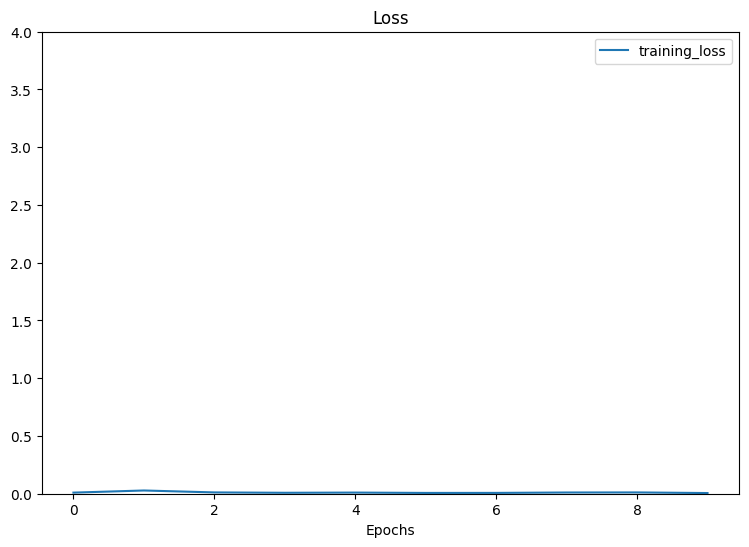

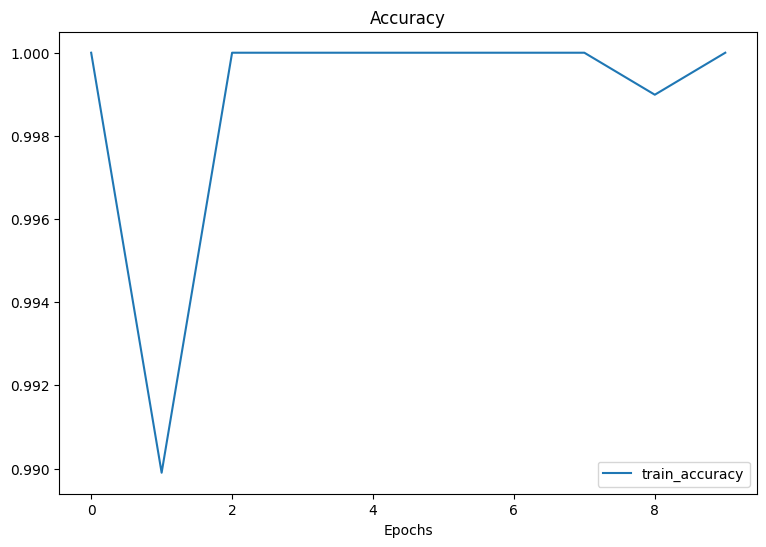

In [ ]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

# Hyperparameters
BEST_LR = 2e-7 # learning rate
BEST_WD= 2e-4 # weight decay
BEST_NUM_EPOCHS = 10 # number of epochs for training
cosine_scheduler = False # Set to True if using cosine decay, False if using fixed learning rate
if cosine_scheduler:
    print(f"Using cosine decay: {cosine_scheduler}")

train_for_more_epochs = False

# Filepath to save/load the model
SAVED_MODEL_FILEPATH = "/home/diogommiranda/tese/outputs/best_model.pth"

# Load saved model or train anew
if train_for_more_epochs:
    model.load_state_dict(torch.load(SAVED_MODEL_FILEPATH, weights_only=True, map_location=device)) # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
else:
    model = ResNet(
        block='basic',
        layers=[3, 4, 6, 3],
        block_inplanes=[64, 128, 256, 512],
        spatial_dims=3,
        n_input_channels=1,
        conv1_t_stride=2,
        num_classes=1,
        shortcut_type='B',
        bias_downsample=False
    )
    model.to(device)

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD)
#optimizer = torch.optim.SGD(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD, momentum=0.9, nesterov=True)

optimizer_name = optimizer.__class__.__name__
optimizer_params = {
    'lr': float(BEST_LR),
    'weight_decay': float(BEST_WD)
}

scheduler = None
if cosine_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7) # T_max=100 for 100 epochs (used in CV)

history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': []}

for epoch in tqdm(range(BEST_NUM_EPOCHS)):
    epoch_start_time = time.time()
    history['epoch'].append(epoch + 1)

    model.train()
    running_loss = 0.0
    train_pred_probs = []
    train_targets = []

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        
        prob_outputs = torch.sigmoid(outputs)
        train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    train_targets = np.array(train_targets).flatten()
    train_pred_probs = np.array(train_pred_probs).flatten()
    
    # Calculate training metrics for the epoch
    train_loss = running_loss / len(train_data.dataset)
    train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
    train_auc = roc_auc_score(train_targets, train_pred_probs)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_auc'].append(train_auc)
        
    epoch_duration = time.time() - epoch_start_time
    print(f"    Epoch {epoch+1}/{BEST_NUM_EPOCHS} [{epoch_duration:.2f}s] - Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")
    
    if scheduler:
        scheduler.step()

# Save the model if using fixed learning rate in case we want to continue training it
if not cosine_scheduler:
    torch.save(model.state_dict(), SAVED_MODEL_FILEPATH)
    print(f"Model saved to: {SAVED_MODEL_FILEPATH}")

plot_loss_curves(history)

# Evaluate the model on the test data
model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")


--- Evaluation Metrics on Test Set ---
Accuracy:    0.9234
Sensitivity: 0.8796
Specificity: 0.9571 
Balanced Accuracy (BACC): 0.9184
F1 Score (Weighted):      0.9230
Matthews Corr Coef (MCC): 0.8444
Area Under the Curve (AUC): 0.9184



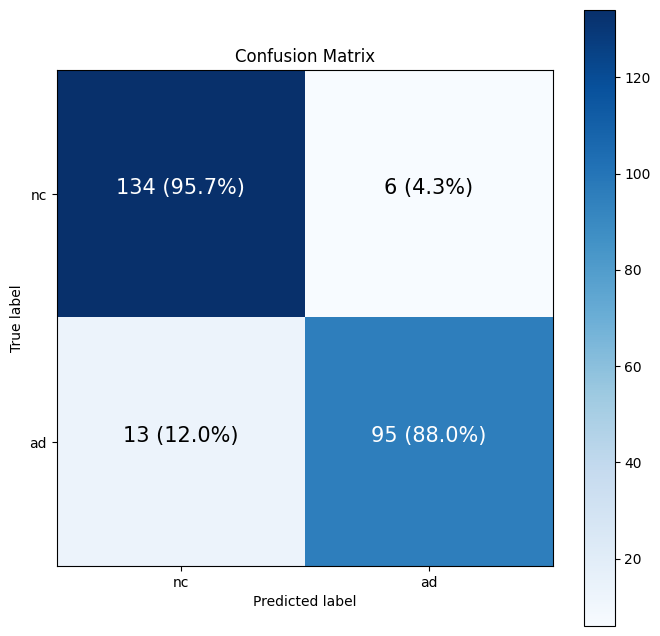

In [17]:
y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


# Save the model

In [ ]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    
    # Configure the right path
    if USE_MASK:
        dir1 = "masked/"
    else:
        dir1 = "full_brain/"
    if cosine_scheduler:
        dir2 = "cosine_decay/"
    else:
        dir2 = "fixed_lr/"
        
    save_model_dir = "/home/diogommiranda/tese/outputs/torch/" + dir1 + DATASET + "/" + dir2 + "saved_models/" + str(BATCH_SIZE) + f"/LR={BEST_LR:.1e}_WD={BEST_WD:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), os.path.join(save_model_dir, "model.pth"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{test_loss}, {test_acc}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")
        
    training_config = {
        "num_epochs": BEST_NUM_EPOCHS,
        "lr_scheduler": lr_scheduler,
        "optimizer": optimizer_name,
        "optimizer_params": {
            "lr": float(BEST_LR),
            "weight_decay": float(BEST_WD)
        },
        "batch_size": BATCH_SIZE,
        "seed": seed,
        "dataset": DATASET
    }
    params_file_path = os.path.join(save_model_dir, "training_config.json")
    with open(params_file_path, "w") as f:
        json.dump(training_config, f, indent=4)

Saving model to: /home/diogommiranda/tese/outputs/torch/full_brain/nc_ad/fixed_lr/saved_models/LR=2.0e-07_WD=2e-04


# Load a model and try it

  Train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312
Test Loss: 0.7523062952638212, Test Acc: 0.8099547511312217

--- Evaluation Metrics on Test Set ---
Accuracy:    0.8100
Sensitivity: 0.7436
Specificity: 0.8462 
Balanced Accuracy (BACC): 0.7949
F1 Score (Weighted):      0.8105
Matthews Corr Coef (MCC): 0.5864
Area Under the Curve (AUC): 0.7949



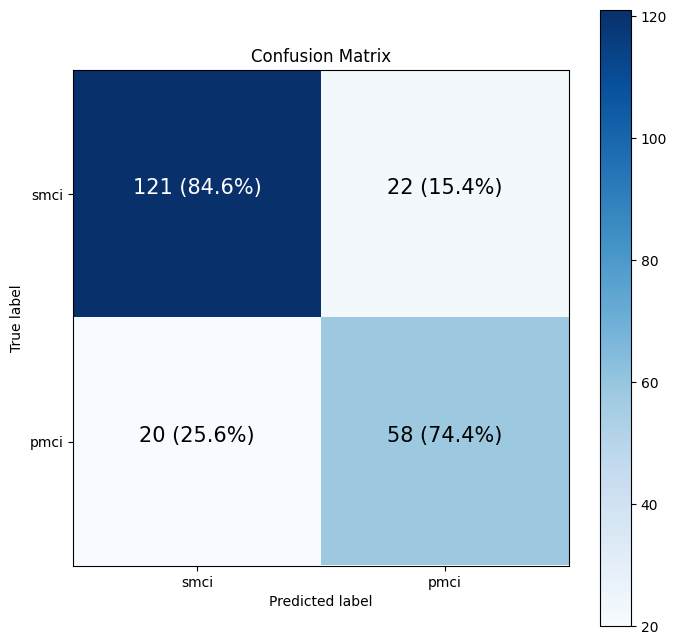

In [12]:
load_model = ResNet(
        block='basic',
        layers=[3, 4, 6, 3],
        block_inplanes=[64, 128, 256, 512],
        spatial_dims=3,
        n_input_channels=1,
        conv1_t_stride=2,
        num_classes=1,
        shortcut_type='B',
        bias_downsample=False
        )
load_model.to(device)
save_model_dir = "/home/diogommiranda/tese/outputs/torch/full_brain/fixed_lr/CROSS_VALIDATION/saved_models/LR=1.0e-05_WD=1e-04 (sgd)"
load_model.load_state_dict(torch.load(os.path.join(save_model_dir, "model.pth"), map_location=device))

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

# Evaluate the model on the test data
load_model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = load_model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)
